## 0. Set envs & Load DB, Model and Tokenizer

### Hyperparameter configuration

In [1]:
import os
import easydict

# Set path
EXP_PATH = os.path.dirname(os.getcwd())
TASK_NAME = 'masked_literal_prediction'
RUN_NAME = 'TransE_NoKGenc_H128'

# Essential Hyperparameters
args = easydict.EasyDict({
    "model_type":"lxmert",
    "model_name_or_path":os.path.join(EXP_PATH,'pretrained_models',RUN_NAME),
    "tokenizer_name":"bert-base-uncased",
    "cache_dir":None,
    "eval_criterion" :"lang_acc,kg_acc",
    "block_size":-1,
    "batch_size":1,
    "eval_data_file": os.path.join(EXP_PATH,"data/{}/valid".format(TASK_NAME)),
    "test_data_file": os.path.join(EXP_PATH, "data/{}/test".format(TASK_NAME)),
    "run_name":RUN_NAME,
    "seed":1234,
})

### Environment settings

In [2]:
# Base packages
import logging
import math
from dataclasses import dataclass, field
from glob import glob
from typing import Optional

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

# Own implementation
from utils.parameters import parser
from utils.dataset import get_dataset
from utils.data_collator import NodeMasking_DataCollator, NodeClassification_DataCollator, LiteralRegression_DataCollator
from model import LxmertForPreTraining, LxmertForKGTokPredAndMaskedLM

# From Huggingface transformers package
from transformers import (
    CONFIG_MAPPING,
    MODEL_WITH_LM_HEAD_MAPPING,
    LxmertConfig,
    LxmertTokenizer,
    PreTrainedTokenizer,
    # Trainer,
    set_seed,
)

# Set enviroments
set_seed(args.seed)

### Load tokenizer

In [3]:
tokenizer = LxmertTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
## Sanity check
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize('Just for sanity check [CLS] [SEP] [MASK] [PAD]')))

[2074, 2005, 20039, 4638, 101, 102, 103, 0]


### Load pretrained model

In [4]:
# Load configuration
config = LxmertConfig.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)


# Load trained model
model = LxmertForKGTokPredAndMaskedLM.from_pretrained(
    args.model_name_or_path,
    from_tf=bool(".ckpt" in args.model_name_or_path),
    config=config,
    cache_dir=args.cache_dir,
)
model.eval()

## Sanity check
print('='*100)
print(model.config)
print('='*100)
print(model)
print('='*100)

LxmertConfig {
  "_name_or_path": "/home/ubuntu/experiments/kg_txt_multimodal/lxmert/pretrained_models/TransE_NoKGenc_H128",
  "architectures": [
    "LxmertForKGTokPredAndMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "contrastive_learning": false,
  "gcn": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "kg_special_token_ids": {
    "MASK": 1,
    "PAD": 0
  },
  "l_layers": 5,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": {
    "kg": 0,
    "lang": 512
  },
  "model_type": "lxmert",
  "negative_samples": 0,
  "num_attention_heads": 8,
  "num_attr_labels": 400,
  "num_hidden_layers": {
    "cross_encoder": 5,
    "language": 5,
    "vision": 0
  },
  "num_kg_labels": 3329,
  "num_object_labels": 1600,
  "num_qa_labels": 9500,
  "pretrained_kg_embedding": "/home/ubuntu/experiments/kg_txt_multimodal/lxmert/from_pretrained/TransE_128/transe.ckpt",
  "r_layers": 0,
  "task_mas

### Load DB & DataLoader

In [5]:
if args.block_size <= 0:
    args.block_size = tokenizer.max_len
    # Our input block size will be the max possible for the model
else:
    args.block_size = min(args.block_size, tokenizer.max_len)

# Get datasets
dataset = (
    get_dataset(args, tokenizer=tokenizer, kg_pad=config.kg_special_token_ids["PAD"], evaluate=True)
)

data_collator = NodeClassification_DataCollator(tokenizer=tokenizer, kg_special_token_ids=config.kg_special_token_ids, kg_size = config.vocab_size['kg'])

# Get data loader
data_loader = DataLoader(
    dataset,
    sampler=SequentialSampler(dataset),
    batch_size=args.batch_size,
    collate_fn=data_collator,
    drop_last=True,
    pin_memory=True,
)

/home/ubuntu/anaconda3/envs/exp/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1372: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  warnings.warn(


## 1. Class-wise accuracy

### Metric for class-wise accuracy

In [6]:
def get_class_wise_accuracy(logit, label, cwa_dict=None):
    _, predicted = torch.max(logit, dim=2)
    active_correct = (predicted == label)[~label.eq(-100)]
    accuracy = active_correct.sum().item()/active_correct.size(0)
    return accuracy

### Measure class-wise accuracy

In [7]:
def prediction_step(
self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]], prediction_loss_only: bool, prediction: bool
):
    # Load tensors to CUDA devices
    for k, v in inputs.items():
        if isinstance(v, torch.Tensor):
            inputs[k] = v.to(self.args.device)
            
    # Eval per minibatch
    with torch.no_grad():
        outputs = model(**inputs)

        if prediction:
            return (outputs[2].detach().numpy(), outputs[3].detach().numpy())

        self.metrics['loss'] += outputs[0].mean().item()
        if not prediction_loss_only:
            if 'lang_acc' in self.eval_criterion:
                self.metrics['lang_acc'] += get_accuracy(outputs[2].data, inputs['lm_label'].data)
            if 'kg_acc' in self.eval_criterion:
                self.metrics['kg_acc'] += get_accuracy(outputs[3].data, inputs['kg_label'].data)
        self.metrics['num_steps']+=1

preds = list()
metrics = [('loss',0.0),('num_steps',0)]
if self.eval_criterion is not None:
    metrics += [(k,0.0) for k in self.eval_criterion]
self.metrics = dict(metrics)
for step, inputs in tqdm(enumerate(dataloader),total=len(dataloader)):
    prediction_step = self.prediction_step(model, inputs, prediction_loss_only, prediction)
    if prediction:
        preds.append(prediction_step)

NameError: name 'Dict' is not defined

## 2. Visualize attention score

### Get attention score from sample

In [42]:
import matplotlib.pyplot as plt

SAMPLE_IDX = 1
for idx, data in enumerate(data_loader):
    if idx==SAMPLE_IDX:
        input_data = data
        break

temp = input_data['lang_input_ids'].cpu().squeeze()
lang_len = len(temp[:temp.nonzero().shape[0]])

temp = input_data['kg_input_ids'].cpu().squeeze()
kg_len = len(temp[:temp.nonzero().shape[0]])

output_data = model(**input_data, output_attentions=True, return_dict=True)

### Cross modal attention

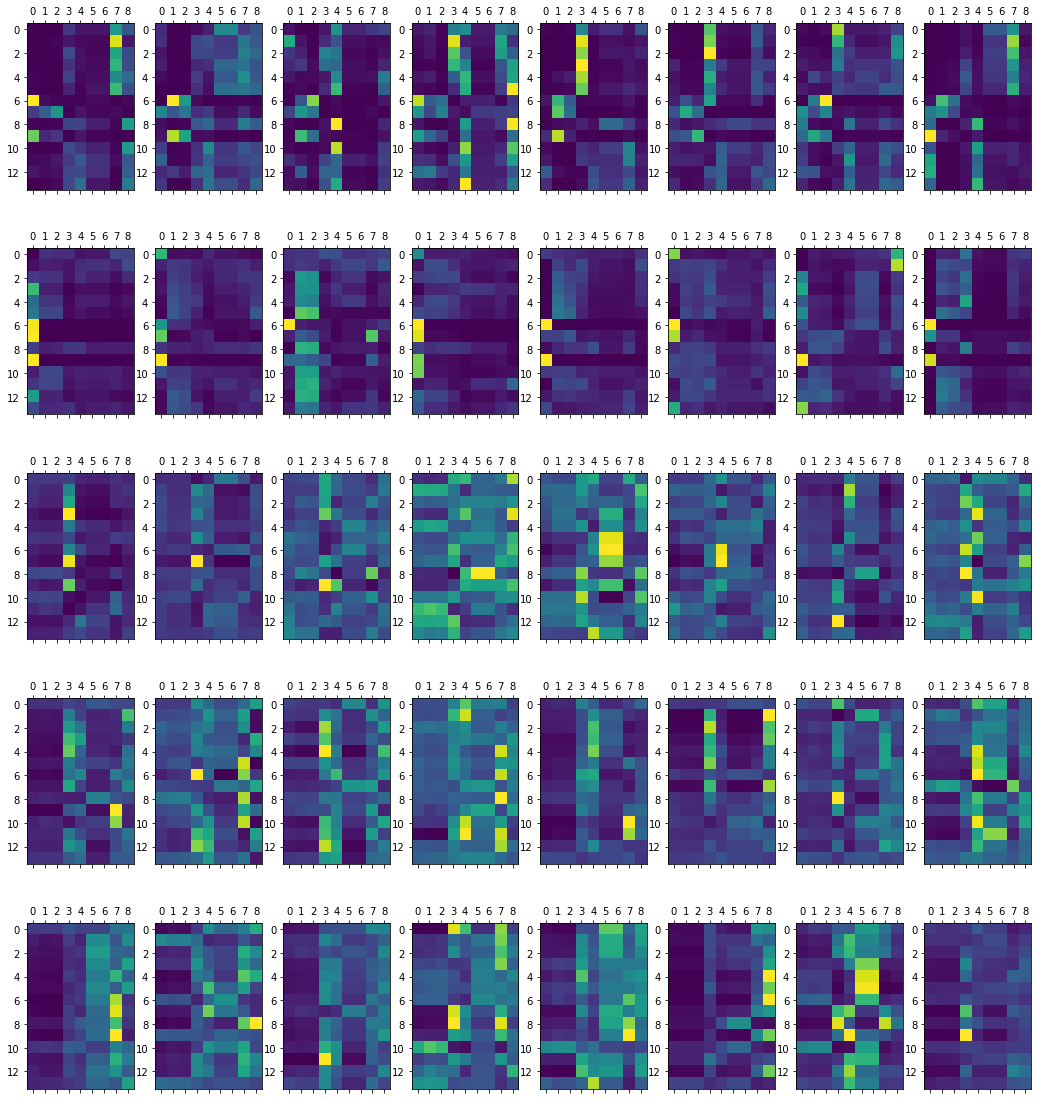

In [43]:
fig, axs = plt.subplots(model.config.x_layers,model.config.num_attention_heads, figsize=(18,20))
for layer_idx in range(model.config.x_layers):
    for head_idx in range(model.config.num_attention_heads):
        axs[layer_idx,head_idx].matshow(
            output_data['cross_encoder_attentions'][layer_idx][0,head_idx,
                                                         :lang_len,:kg_len].cpu().detach().numpy(),
            #cmap='gray',
        )

### Language attention

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


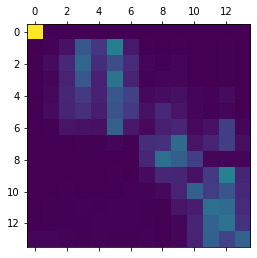

In [44]:
import matplotlib.pyplot as plt

HEAD_IDX=2

output_data = model(**input_data, output_attentions=True, return_dict=True)

plt.matshow(
    output_data['language_attentions'][4][0,HEAD_IDX,
                                                 :lang_len,:lang_len].cpu().detach().numpy(),
    #cmap='gray'
)

print(output_data['language_attentions'][4][0,HEAD_IDX,
                                                 :lang_len,:lang_len].sum(1))